In [7]:
library(R6)
library(ggplot2)

# Define the ParallelogramOptimizer class
ParallelogramOptimizer <- R6Class("ParallelogramOptimizer",
  public = list(
    x = NULL,
    y = NULL,
    y0 = NULL,
    y1 = NULL,
    params = NULL,

    initialize = function(x, y) {
      self$x <- x
      self$y <- y
      self$y0 <- min(y)
      self$y1 <- max(y)
      self$params <- NULL
    },

    get_corners = function(x0, y0, x1, y1, slope) {
      if (slope == 0) {
        lower_left <- c(x0, y0)
        lower_right <- c(x1, y0)
        upper_left <- c(x0, y1)
        upper_right <- c(x1, y1)
      } else {
        height <- y1 - y0
        delta_x <- height / slope

        if (abs(slope) > 1e3) {
          delta_x <- 0
        }

        lower_left <- c(x0, y0)
        lower_right <- c(x1, y0)
        upper_left <- c(x0 + delta_x, y1)
        upper_right <- c(x1 + delta_x, y1)
      }

      return(list(lower_left, lower_right, upper_right, upper_left))
    },

    constraints = function(params) {
      x0 <- params[1]
      x1 <- params[2]
      slope <- params[3]
      constraint_vals <- numeric()

      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)
      lower_left <- corners[[1]]
      lower_right <- corners[[2]]
      upper_right <- corners[[3]]
      upper_left <- corners[[4]]

      for (i in seq_along(self$x)) {
        xi <- self$x[i]
        yi <- self$y[i]

        y_lower <- if (xi <= lower_right[1]) self$y0 else self$y0 + slope * (xi - lower_right[1])
        y_upper <- if (xi >= upper_left[1]) self$y1 else self$y1 + slope * (xi - upper_left[1])

        x_lower <- min(lower_left[1], upper_left[1])
        x_upper <- max(upper_right[1], lower_right[1])

        constraint_vals <- c(constraint_vals, y_upper - yi)
        constraint_vals <- c(constraint_vals, yi - y_lower)
        constraint_vals <- c(constraint_vals, xi - x_lower)
        constraint_vals <- c(constraint_vals, x_upper - xi)
      }
      return(constraint_vals)
    },

    objective = function(params) {
      x0 <- params[1]
      x1 <- params[2]
      slope <- params[3]
      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)
      v1 <- corners[[2]] - corners[[1]]
      v2 <- corners[[4]] - corners[[1]]
      area <- abs(v1[1] * v2[2] - v1[2] * v2[1])

      c_penalty <- min(self$constraints(params))
      if (c_penalty > 0){
        c_penalty <- 0
      }
      return(area + 1e3 * c_penalty^2)
    },

    optimize_parallelogram = function() {
      x0_initial <- min(self$x)
      x1_initial <- max(self$x)
      slope_initial <- (self$y1 - self$y0) / (x1_initial - x0_initial)

      initial_guess <- c(x0_initial, x1_initial, slope_initial)

      result <- optim(
        par = initial_guess,
        fn = self$objective,
        method = "L-BFGS-B",
        lower = c(-Inf, -Inf, 0),
        upper = c(Inf, Inf, Inf)
      )

      self$params <- result$par
      return(self$params)
    },

plot_parallelogram = function(existing_plot = NULL, params = NULL) {
  # Use the provided params or fall back to self$params
  if (is.null(params)) {
    if (is.null(self$params)) {
      stop("Parameters are not optimized yet. Run parallelogram_truncation() first.")
    }
    params <- self$params
  }

  x0 <- params[1]
  x1 <- params[2]
  slope <- params[3]

  corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)

  parallelogram_x <- c(corners[[1]][1], corners[[2]][1], corners[[3]][1], corners[[4]][1], corners[[1]][1])
  parallelogram_y <- c(corners[[1]][2], corners[[2]][2], corners[[3]][2], corners[[4]][2], corners[[1]][2])

  df <- data.frame(x = parallelogram_x, y = parallelogram_y)

  if (is.null(existing_plot)) {
    stop("No existing plot provided for overlay.")
  }

  # Overlay parallelogram on existing plot
  p <- existing_plot +
    geom_path(data = df, aes(x = x, y = y), color = "purple", size = 1) +
    geom_segment(aes(x = corners[[1]][1], y = corners[[1]][2], xend = corners[[3]][1], yend = corners[[3]][2]),
                 color = "purple", linetype = "dashed") +
    geom_segment(aes(x = corners[[2]][1], y = corners[[2]][2], xend = corners[[4]][1], yend = corners[[4]][2]),
                 color = "purple", linetype = "dashed")

  # p <- existing_plot

  print(p)
}
  )
)

# **Region Fitter**:

In [8]:
# Load R6 package
library(R6)

# Define the InflectionPointSeeker class
RegionFitter <- R6Class("RegionFitter",
  public = list(
    data = NULL,  # Store the ROI object
    poi = NULL,
    fit_type = NULL,
    direction = NULL,

    # Constructor to initialize the object with parameters
    initialize = function(data, poi, direction = 'left', fit_type = "linear") {
      self$data <- data
      self$poi <- poi
      self$direction <- direction
      self$fit_type <- fit_type
    },
    # linear fit equation: y = ax+k
    linear = function(x, params){
      return (params[0]*(x-self$poi$x) + self$po$y)
    }
    # parabolic fit equation: y=a(x-h)^2 + k, where vertext is at (h,k)
    parabola = function(x, params){
      # return (params[0]*(x-self$poi$x)^2 + params[1]*(x-self$poi$x) + self$poi$y) #TODO is ^ power or bitwise operator?
      return params[0]*(x-self$poi$x)^2 + self$poi$y #TODO is ^ power or bitwise operator?
    }

    objective = function(params){
        # """
        # for all data points
        # l2 = compute the l2-distance from y_truth to y_fit
        # distance += l2
        # """

        if(self$fit_type == 'linear'){
          fit_function <- self$linear
        }
        if(self$fit_type == 'parabola'){
          fit_function <- self$parabola
        }

        n_data = len(self$data$x)
        cost <- 0
        for (i in seq_along(n_data)) {
          ''' make sure you only take the data points you need (i.e., left and right of the point)'''
          if(self$direction == 'left'){


          }

          xi <- self$data$x[i]
          y_truth <- self$data$y[i]
          y_fit <- fit_function(xi, params)
          cost <- cost + (y_truth - y_fit)^2
        }
        return (cost)
    }

    # Method to create the grid of points
    fit = function() {
      slope_initial <- (self$point$y - self$y0) / (x1_initial - x0_initial)
      initial_guess <- c(slope_initial)
      result <- optim(
        par = initial_guess,
        fn = self$objective,
        method = "L-BFGS-B",
        lower = c(-Inf),
        upper = c(Inf)
      )

      self$params <- result$par
      return(self$params)
    },
  )
)



# **Region Fitter WIP**

In [ ]:
# Objective function to fit two lines with constraint they pass through poi
objective_function <- function(params, x, y, poi_x, poi_y) {
  # Extract the slopes for the left and right lines
  m1 <- params[1]
  m2 <- params[2]

  # Split the data into left and right of the poi_x
  left_indices <- which(x <= poi_x)
  right_indices <- which(x > poi_x)

  # Calculate predicted values for the left and right lines
  y_pred_left <- m1 * (x[left_indices] - poi_x) + poi_y
  y_pred_right <- m2 * (x[right_indices] - poi_x) + poi_y

  # Calculate residuals (difference between actual and predicted values)
  residuals_left <- y[left_indices] - y_pred_left
  residuals_right <- y[right_indices] - y_pred_right

  # Sum of squared residuals
  total_residuals <- sum(residuals_left^2) + sum(residuals_right^2)

  return(total_residuals)  # This is the value to minimize
}

# Data


x <- seq(-10, 10, length.out = 100)
y <- 2 * x + rnorm(100, 0, 5)  # Generate some data with noise

# Point of interest (POI)
poi_x <- 0
poi_y <- 0  # Assume POI is (0, 0) for simplicity

# Split the data into left and right of the poi_x
left_indices <- which(x <= poi_x)
right_indices <- which(x > poi_x)

# Initial guesses for the slopes:
# Left slope (m1) is the slope between the first point on the left and the POI
m1_initial <- (y[left_indices][1] - poi_y) / (x[left_indices][1] - poi_x)

# Right slope (m2) is the slope between the POI and the last point on the right
m2_initial <- (y[right_indices][length(right_indices)] - poi_y) /
              (x[right_indices][length(right_indices)] - poi_x)

initial_params <- c(m1 = m1_initial, m2 = m2_initial)

# Minimize the objective function using optim
result <- optim(par = initial_params, fn = objective_function, x = x, y = y, poi_x = poi_x, poi_y = poi_y)

# Extract the optimal slopes
optimal_m1 <- result$par[1]
optimal_m2 <- result$par[2]

# Print the results
cat("Optimal slope for the left line (m1):", optimal_m1, "\n")
cat("Optimal slope for the right line (m2):", optimal_m2, "\n")

# Plot the data and the fitted lines
plot(x, y, main = "Fitted Lines Passing Through POI", xlab = "x", ylab = "y", pch = 16, col = "blue")

# Add the fitted lines to the plot
abline(a = poi_y - optimal_m1 * poi_x, b = optimal_m1, col = "red")  # Left line
abline(a = poi_y - optimal_m2 * poi_x, b = optimal_m2, col = "green")  # Right line

# Add the POI to the plot
points(poi_x, poi_y, col = "black", pch = 19, cex = 2)


# **Inflection Point Seeker**

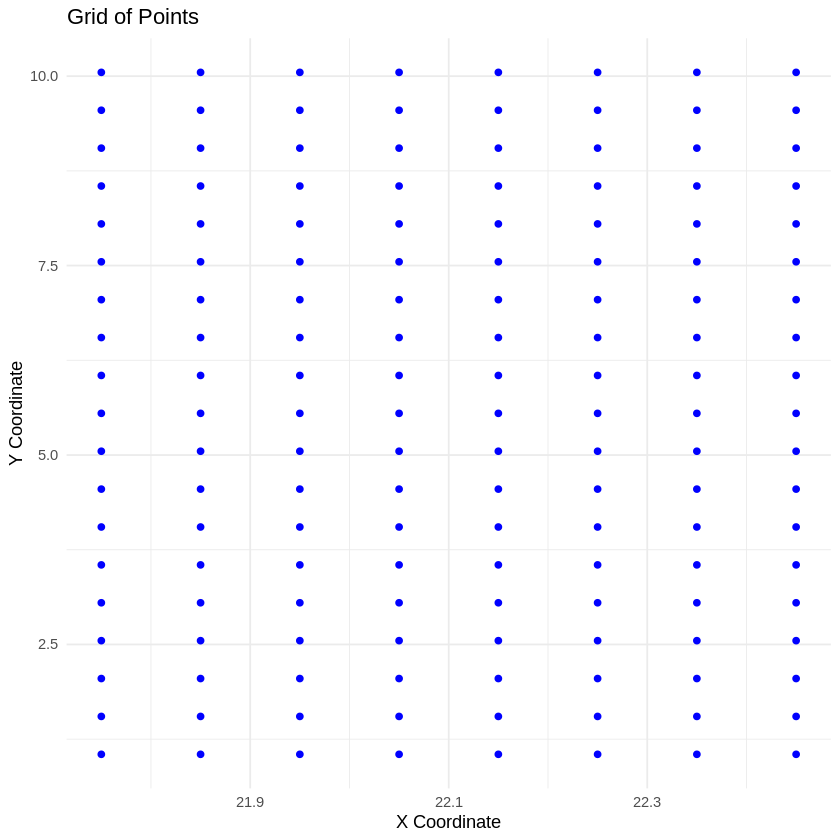

In [9]:
# Load R6 package
library(R6)
library(ggplot2)

# Define the InflectionPointSeeker class
InflectionPointSeeker <- R6Class("InflectionPointSeeker",
  public = list(
    roi = NULL,  # Store the ROI object
    step_x = NULL,
    step_y = NULL,

    # Constructor to initialize the object with parameters
    initialize = function(roi, step_x, step_y) {
      self$roi <- roi
      self$step_x <- step_x
      self$step_y <- step_y
    },

    # Method to create the grid of points
    make_grid = function() {
      # Extract xmin, xmax, ymin, ymax from ROI
      xmin <- self$roi$x[1]
      xmax <- self$roi$x[2]
      ymin <- self$roi$y[1]
      ymax <- self$roi$y[2]

      # Generate sequences for x and y coordinates
      x_seq <- seq(from = xmin, to = xmax, by = self$step_x)
      y_seq <- seq(from = ymin, to = ymax, by = self$step_y)

      # Create a grid of points
      grid_points <- expand.grid(x = x_seq, y = y_seq)

      # Return the grid points
      return(grid_points)
    }
  )
)

roi<- list(
          x = c(21.750, 22.475),
          y = c(1.05, 10.50)
        )
# Create an instance of the InflectionPointSeer class
grid_maker <- InflectionPointSeeker$new(
  roi = roi,  # Pass the ROI object
  step_x = 0.1,  # Define step size in x direction
  step_y = 0.5   # Define step size in y direction
)

# Call the make_grid method
grid_points <- grid_maker$make_grid()


# Plot the grid using ggplot2
pgrid<- ggplot(grid_points, aes(x = x, y = y)) +
  geom_point(color = "blue") +  # Plot points in blue
  labs(title = "Grid of Points", x = "X Coordinate", y = "Y Coordinate") +
  theme_minimal()  # Use a clean theme

print(pgrid)

Warning message in seq_len(self$trimmed_data$x - 1):
“first element used of 'length.out' argument”


Parallelogram Parameters:
[1] 21.09111 22.40192 12.24951
i'm at case 1 !!!

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


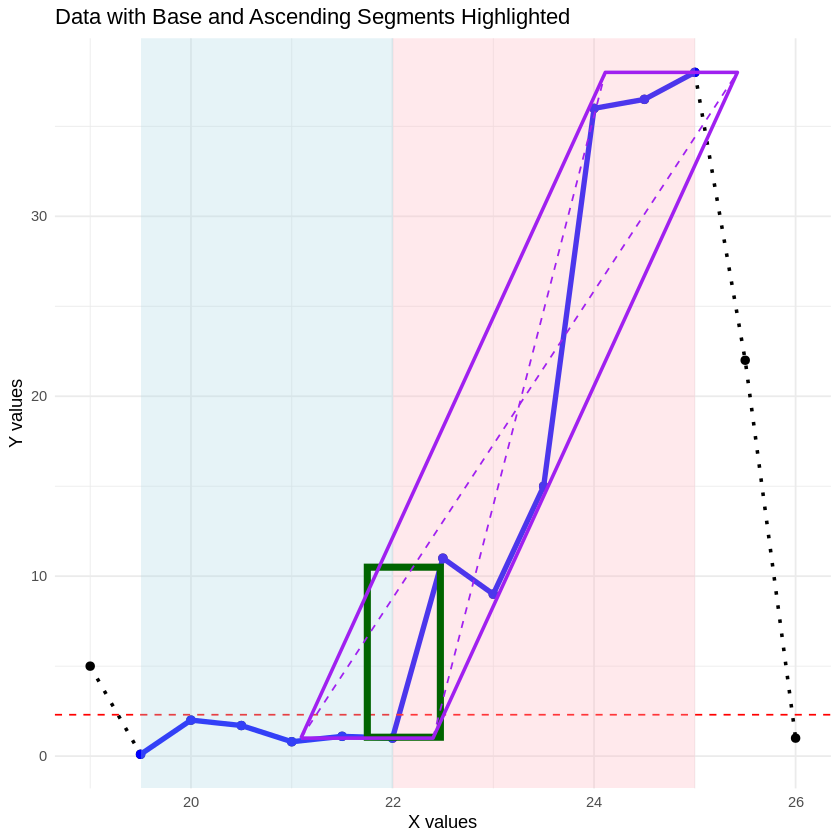

In [11]:
library(R6)
library(ggplot2)

# Define the DataProcessor class
DataProcessor <- R6Class("DataProcessor",
  public = list(
    input_data = NULL,
    threshold = NULL,
    trimmed_data = NULL,
    parallelogram_optimizer = NULL,
    parallelogram_params = NULL,
    n_data = NULL,
    roi = NULL,

    # Constructor to initialize data and threshold
    initialize = function(input_data, threshold) {
      self$input_data <- input_data
      self$threshold <- threshold
      self$trimmed_data <- self$clean_data()
      self$n_data <- length(self$trimmed_data$x)  # Assuming 'x' represents the length of the data points

      # Initialize base, ascending, and intermediate segments as vectors of zeros
      self$trimmed_data$base <- rep(0, self$n_data - 1)
      self$trimmed_data$ascending <- rep(0, self$n_data - 1)
      self$trimmed_data$intermediate <- rep(0, self$n_data - 1)


      self$identify_base_segments()
      #self$check_base_profile_consistency() #TODO
      self$identify_ascending_segments()
      self$truncate_ascending_segments()  # Added method call
      self$identify_intermediate_segments()

      self$parallelogram_truncation()

      self$get_area_of_interest()

      self$plot_data_with_segments()  # Plotting after all processing
    },

    # Method to clean data by filtering based on the threshold on y_values
    clean_data = function() {
      x_values <- self$input_data$x
      y_values <- self$input_data$y
      above_threshold <- which(y_values > self$threshold)
      if (length(above_threshold) == 0) {
        return(list(x = x_values, y = y_values))
      }
      last_above <- max(above_threshold)
      cleaned_x <- x_values[1:last_above]
      cleaned_y <- y_values[1:last_above]
      return(list(x = cleaned_x, y = cleaned_y))
    },

    # Method to calculate slopes between data points
    calculate_slopes = function(data) {
      y_values <- data$y
      slopes <- numeric(length(y_values) - 1)
      for (i in 1:(length(y_values) - 1)) {
        slopes[i] <- y_values[i + 1] - y_values[i]
      }
      return(slopes)
    },

    # Method to identify base segments
    identify_base_segments = function() {
      slopes <- self$calculate_slopes(self$trimmed_data)
      y_values <- self$trimmed_data$y
      for (i in 1:(length(slopes))) {
        if (is.na(slopes[i]) || is.na(y_values[i]) || is.na(y_values[i + 1])) {
          next  # Skip if any value is NA
        }
        if (slopes[i] <= 0 && (y_values[i] <= self$threshold || y_values[i + 1] <= self$threshold)) {
          self$trimmed_data$base[i] <- 1
        }
      }
      rightmost_base <- which(self$trimmed_data$base == 1)
      if (length(rightmost_base) > 0) {
        self$trimmed_data$base[1:max(rightmost_base) + 1] <- 1
      }
    },

    # Method to check profile consistency for base segments only
    check_base_profile_consistency = function() {
      slopes <- self$calculate_slopes(self$trimmed_data)
      y_values <- self$trimmed_data$y
      for (i in which(self$trimmed_data$base == 1)) {
        if (i < length(y_values)) {
          if (is.na(y_values[i]) || is.na(y_values[i + 1])) {
            print(paste("Warning: NA value found at index", i))
            next  # Skip this iteration if NA is found
          }

          if (y_values[i] > self$threshold && y_values[i + 1] <= self$threshold) {
            print(paste("Warning: Descends across threshold at base segment index", i))
            warning("Profile consistency at base part: no (descends across threshold)")
          }

          if (abs(slopes[i]) > 0.5 * self$threshold) {
            print(paste("Warning: Large difference between nodes at base segment index", i))
            warning("Profile consistency at base part: no (large difference between nodes)")
          }
        }
      }
    },

    # Method to identify the initial ascending segments
    identify_ascending_segments = function() {
      x_values <- self$trimmed_data$x
      y_values <- self$trimmed_data$y

      # Find the index where the data first crosses the threshold in an ascending manner
      start_index <- which(y_values > self$threshold & c(FALSE, diff(y_values) > 0))[1]

      if (!is.na(start_index)) {
        # Include the segment immediately before the first crossing
        if (start_index > 1) {
          self$trimmed_data$ascending[start_index - 1] <- 1
        }

        # Identify the ascending segments
        for (i in start_index:(length(y_values) - 1)) {
          if (y_values[i] > self$threshold) {
            self$trimmed_data$ascending[i] <- 1
          } else {
            break
          }
        }
      }
    },

    # Method to truncate ascending segments and update trimmed data
    truncate_ascending_segments = function() {
      y_values <- self$trimmed_data$y
      x_values <- self$trimmed_data$x
      last_ascending_index <- max(which(self$trimmed_data$ascending == 1))

      # Ensure that last_ascending_index is valid
      if (is.na(last_ascending_index) || last_ascending_index == length(y_values)) {
        return()  # Nothing to truncate
      }

      # Loop backwards from the end of the ascending region
      while (last_ascending_index > 1) {
        if (y_values[last_ascending_index + 1] > y_values[last_ascending_index]) {
          self$trimmed_data$ascending[last_ascending_index + 1] <- 1
          break  # Stop if the last segment is positively sloped
        }
        self$trimmed_data$ascending[last_ascending_index] <- 0
        last_ascending_index <- last_ascending_index - 1
      }

      # Truncate the trimmed data to ensure no intermediate segments exist beyond the last ascending point
      self$trimmed_data$x <- x_values[1:last_ascending_index+1]
      self$trimmed_data$y <- y_values[1:last_ascending_index+1]

      self$trimmed_data$base <- self$trimmed_data$base[1:last_ascending_index+1]
      self$trimmed_data$ascending <- self$trimmed_data$ascending[1:last_ascending_index+1]
      self$trimmed_data$intermediate <- self$trimmed_data$intermediate[1:last_ascending_index+1]

      #print(paste("trimmed_data_x:", self$trimmed_data$x))
      #print(paste("trimmed_data_y:", self$trimmed_data$y))
    },

    # Method to identify intermediate segments
    identify_intermediate_segments = function() {
      #  print(paste("trimmed_data:", self$trimmed_data$x))
      for (i in seq_len(self$trimmed_data$x - 1)) {
        # Check if both ascending and base are not 1 at index i
        if (!is.na(self$trimmed_data$ascending[i]) &&
            !is.na(self$trimmed_data$base[i]) &&
            self$trimmed_data$ascending[i] != 1 &&
            self$trimmed_data$base[i] != 1) {
          self$trimmed_data$intermediate[i] <- 1
        }
      }
    },

    # Method to get data nodes from logical segment vectors
    get_nodes = function() {
      segments <- list(
        base = integer(0),
        ascending = integer(0),
        intermediate = integer(0)
      )
      for (i in seq_len(length(self$trimmed_data$x) - 1)) {
        for (key in names(segments)) {
          data_vector <- self$trimmed_data[[key]] # Changed to input_data


          # Ensure data_vector is not null and is a valid vector
          if (is.null(data_vector) || !is.vector(data_vector)) {
            print(paste("Data vector for key", key, "is NULL or not a vector"))
            next
          }

          # Check index bounds
          if (i <= length(data_vector)) {
            if (!is.na(data_vector[i]) && data_vector[i] == 1) {
              segments[[key]] <- c(segments[[key]], i)
            }
          } else {
          }
        }
      }
      return(segments)
    },

    parallelogram_truncation = function() { ## TODO: ACTUALLY TRUNCATE BASED ON THIS
      x_values <- self$trimmed_data$x[which(self$trimmed_data$ascending==1)]
      y_values <- self$trimmed_data$y[which(self$trimmed_data$ascending==1)]

      #optimizer <- ParallelogramOptimizer$new(
        #x = x_values,
       # y = y_values
      #)
         # Create an instance of ParallelogramOptimizer and store it
      self$parallelogram_optimizer <- ParallelogramOptimizer$new(
        x = x_values,
        y = y_values
      )


      #params <- optimizer$optimize_parallelogram()
      params <- self$parallelogram_optimizer$optimize_parallelogram()
        # Plot and ensure it renders
      #cat("Plotting the parallelogram...\n")
      # optimizer$plot_parallelogram()

      cat("Parallelogram Parameters:\n")
      print(params)
      self$parallelogram_params <- params
      # return(params)
    },

    # Method to define region of interest
    get_area_of_interest = function() {
      segments <- self$get_nodes()
      # Ensure that base and ascending segments are not empty
      if (length(segments$base) > 0 && length(segments$ascending) > 0) {

        # Check for intermediate segments
        if (length(segments$intermediate) == 0) {
          # No intermediate segment

          # Check if the last base and first ascending segments are contiguous
          if (segments$base[length(segments$base)] == segments$ascending[1]) {
            cat("i'm at case 1 !!!")
            # Case 1: No intermediate segment and base/ascending are contiguous
            # Print individual segment calculations
            # print(paste("Base segment:", segments$base))
            # print(paste("base data:", self$trimmed_data$x[segments$base]))
            # print(paste("Ascending segment:", segments$ascending))
            # print(paste("ascend data:", self$trimmed_data$x[segments$ascending]))
            start <- (self$trimmed_data$x[segments$base[length(segments$base)]] +
                      self$trimmed_data$x[segments$base[length(segments$base) - 1]]) / 2
            end <- 0.95 * (self$trimmed_data$x[segments$ascending[2]] -
                           self$trimmed_data$x[segments$ascending[1]]) +
                           self$trimmed_data$x[segments$ascending[1]]

            lower <- (self$trimmed_data$y[segments$base[length(segments$base)]] +
                      self$trimmed_data$y[segments$base[length(segments$base) - 1]]) / 2
            upper <- 0.95 * (self$trimmed_data$y[segments$ascending[2]] -
                             self$trimmed_data$y[segments$ascending[1]]) +
                             self$trimmed_data$y[segments$ascending[1]]

          } else {
            # Case 3: No nodes below the node separating base and ascending segments
            cat("i'm at case 3 !!!")
            start <- self$trimmed_data$x[segments$ascending[1]]
            end <- 0.95 * (self$trimmed_data$x[segments$ascending[2]] -
                           self$trimmed_data$x[segments$ascending[1]]) +
                           self$trimmed_data$x[segments$ascending[1]]

            lower <- self$trimmed_data$y[segments$ascending[1]]
            upper <- 0.95 * (self$trimmed_data$y[segments$ascending[2]] -
                             self$trimmed_data$y[segments$ascending[1]]) +
                             self$trimmed_data$y[segments$ascending[1]]
          }

        } else {
          # Case 2: Intermediate segments exist
          cat("i'm at case 2 !!!")
          # Exclude the leftmost node of the first intermediate segment
          start <- self$trimmed_data$x[segments$intermediate[2]]
          end <- 0.95 * (self$trimmed_data$x[segments$ascending[2]] -
                         self$trimmed_data$x[segments$ascending[1]]) +
                         self$trimmed_data$x[segments$ascending[1]]

          lower <- self$trimmed_data$y[segments$intermediate[2]]
          upper <- 0.95 * (self$trimmed_data$y[segments$ascending[2]] -
                           self$trimmed_data$y[segments$ascending[1]]) +
                           self$trimmed_data$y[segments$ascending[1]]
        }

        area <- list(
          x = c(start, end),
          y = c(lower, upper)
        )

        self$roi <- area
        # return(area)
        # Print individual segment calculations
        # print(paste("Base segment end index:", segments$base[length(segments$base)]))
        # print(paste("Ascending segment start index:", segments$ascending[1]))

        # print(paste("Area of interest starts at x =", start, "and ends at x =", end))
        # print(paste("Corresponding y-values range from", lower, "to", upper))
      }
    },

    # Method to plot data and identified segments
plot_data_with_segments = function() {
    x_values <- self$input_data$x
    y_values <- self$input_data$y
    trimmed_x <- self$trimmed_data$x
    trimmed_y <- self$trimmed_data$y

    base_seg <- self$trimmed_data$base
    base_segments <- base_seg == 1
    ascending_seg <- self$trimmed_data$ascending
    ascending_segments <- ascending_seg == 1

    # Create data frames for plotting
    plot_data <- data.frame(x = x_values, y = y_values)
    trimmed_plot_data <- data.frame(x = trimmed_x, y = trimmed_y)

    # Create shaded areas for base and ascending segments
    shaded_area_data_base <- data.frame(
      xmin = numeric(),
      xmax = numeric(),
      ymin = numeric(),
      ymax = numeric()
    )

    shaded_area_data_ascending <- data.frame(
      xmin = numeric(),
      xmax = numeric(),
      ymin = numeric(),
      ymax = numeric()
    )

    # Determine base segments area
    if (any(base_segments)) {
      first_true <- which(base_segments)[1]
      last_true <- tail(which(base_segments), 1)

      shaded_area_data_base <- data.frame(
        xmin = self$trimmed_data$x[first_true],
        xmax = self$trimmed_data$x[last_true],  # Ensure right boundary
        ymin = -Inf,
        ymax = Inf
      )
      shaded_area_data_base <- shaded_area_data_base[order(shaded_area_data_base$xmin), ]
    }

    # Determine ascending segments area
    if (any(ascending_segments)) {
      first_true <- which(ascending_segments)[1]
      last_true <- tail(which(ascending_segments), 1)

      shaded_area_data_ascending <- data.frame(
        xmin = self$trimmed_data$x[first_true],
        xmax = self$trimmed_data$x[last_true],  # Ensure right boundary
        ymin = -Inf,
        ymax = Inf
      )
      shaded_area_data_ascending <- shaded_area_data_ascending[order(shaded_area_data_ascending$xmin), ]
    }

    # Initialize the ggplot object
    p <- ggplot() +
      # Raw data as black dotted line
      geom_line(data = plot_data, aes(x = x, y = y), linetype = "dotted", color = "black", linewidth = 1) +
      geom_point(data = plot_data, aes(x = x, y = y), color = "black", size = 2) +

      # Trimmed data as thicker blue line
      geom_line(data = trimmed_plot_data, aes(x = x, y = y), color = "blue", linewidth = 1.5) +
      geom_point(data = trimmed_plot_data, aes(x = x, y = y), color = "blue", size = 2) +

      # Horizontal line for threshold
      geom_hline(yintercept = self$threshold, linetype = "dashed", color = "red") +

      # Add labels and theme
      labs(title = "Data with Base and Ascending Segments Highlighted", x = "X values", y = "Y values") +
      theme_minimal()

    # Overlay shaded areas behind base segments and ascending segments
      if (nrow(shaded_area_data_base) > 0) {
        p <- p + geom_rect(data = shaded_area_data_base, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = "lightblue", alpha = 0.3, color = NA)
      }
      if (nrow(shaded_area_data_ascending) > 0) {
        p <- p + geom_rect(data = shaded_area_data_ascending, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = "lightpink", alpha = 0.3, color = NA)
      }

      if(!is.null(self$roi)){
         roi_box <- data.frame(
        xmin = self$roi$x[1],
        xmax = self$roi$x[2],  # Ensure right boundary
        ymin = self$roi$y[1],
        ymax = self$roi$y[2]
      )
        p<- p+geom_rect(data = roi_box, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = NA, alpha = 0.3, color = "darkgreen", linewidth=2)
      }


      # Return the plot
      return(p)


    },


    # Method to plot parallelogram
    plot_parallelogram = function(existing_plot = NULL, params = NULL) {
      # Check if the optimizer is available
      if (is.null(self$parallelogram_optimizer)) {
        stop("ParallelogramOptimizer instance is not available. Run parallelogram_truncation() first.")
      }
      # Plot the parallelogram using the stored optimizer
      self$parallelogram_optimizer$plot_parallelogram(existing_plot, params)
    }
  )
)

# Example usage:
all_data <- list(
  x = c(19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26),
  y = c(5, 0.1, 2.0, 1.7, 0.8, 1.1, 1, 11, 9, 15, 36, 36.5, 38, 22, 1)
)

threshold <- 2.3

# Create a DataProcessor object
processor <- DataProcessor$new(all_data, threshold)

# Print results
# print("input data:")
# print(processor$input_data)
# print("Base segments:")
# print(processor$input_data$base)
# print("Ascending segments:")
# print(processor$input_data$ascending)
# print("Intermediate segments:")
# print(processor$input_data$intermediate)

#cleanedupdatax = processor$trimmed_data$x
#cleanedupdatay = processor$trimmed_data$y

#print(paste("trim x:", cleanedupdatax))
#print(paste("trim y:", cleanedupdatay))
# Plot the raw data with base and ascending segments highlighted
base_plot<-processor$plot_data_with_segments()

# Perform parallelogram truncation on the truncated ascending segments and plot the parallelogram

# overlay parallelogram plot

processor$plot_parallelogram(existing_plot = base_plot, params = processor$parallelogram_params)